# What if... I take all the features, run the VIF and fit the model with the filtered features?

In [1244]:
import pandas as pd
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tinyshift.stats import BootstrapBCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score


In [1245]:
df = pd.read_csv("./data/cancer_reg.csv", encoding='iso-8859-1')

In [1246]:
df = df[df['MedianAge'] <= 90]

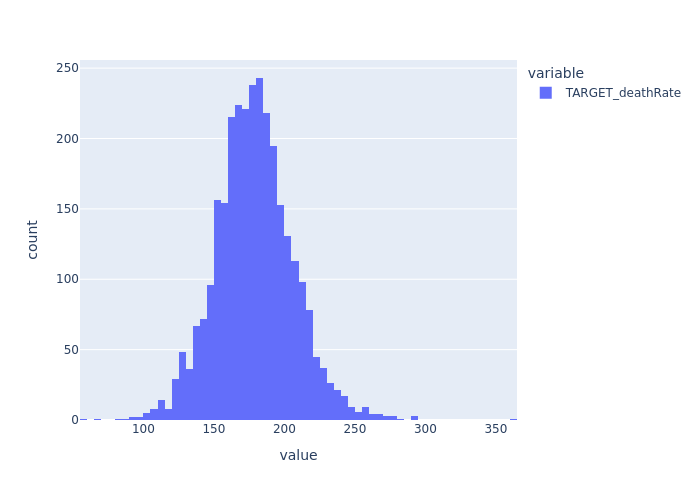

In [1247]:
fig = px.histogram(df["TARGET_deathRate"])
fig.show("png")

In [1248]:
df["TARGET_deathRate"].var() > df["TARGET_deathRate"].mean()

True

In [1249]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

## Percentage of Total of NaN Data for Each Column

In [1250]:
df.isnull().sum() / len(df)

avgAnnCount                0.000000
avgDeathsPerYear           0.000000
TARGET_deathRate           0.000000
incidenceRate              0.000000
medIncome                  0.000000
popEst2015                 0.000000
povertyPercent             0.000000
studyPerCap                0.000000
binnedInc                  0.000000
MedianAge                  0.000000
MedianAgeMale              0.000000
MedianAgeFemale            0.000000
Geography                  0.000000
AvgHouseholdSize           0.000000
PercentMarried             0.000000
PctNoHS18_24               0.000000
PctHS18_24                 0.000000
PctSomeCol18_24            0.750083
PctBachDeg18_24            0.000000
PctHS25_Over               0.000000
PctBachDeg25_Over          0.000000
PctEmployed16_Over         0.049387
PctUnemployed16_Over       0.000000
PctPrivateCoverage         0.000000
PctPrivateCoverageAlone    0.199536
PctEmpPrivCoverage         0.000000
PctPublicCoverage          0.000000
PctPublicCoverageAlone     0

In [1251]:
df = df.drop(columns=["PctSomeCol18_24", "PctPrivateCoverageAlone"])

In [1252]:
bca = BootstrapBCA()
bca.compute_interval(df["PctEmployed16_Over"].dropna(), confidence_level=0.95, statistic=np.mean, n_resamples=1000)

(53.82614569603778, 54.43873685962987)

In [1253]:
df["PctEmployed16_Over"] = df["PctEmployed16_Over"].fillna(np.ceil(df["PctEmployed16_Over"].mean()))

In [1254]:
features_in = [
"avgAnnCount",
"PctPrivateCoverage",
"PctPublicCoverage",
"PctBachDeg25_Over",
"PercentMarried",
"incidenceRate",
"povertyPercent",
"MedianAge",
"medIncome",
"PctWhite",
"PctBlack",
"PctAsian",
"PctOtherRace",
"avgDeathsPerYear",
]
target = "TARGET_deathRate"

In [1255]:
df[features_in].corr(numeric_only=True)

,avgAnnCount,PctPrivateCoverage,PctPublicCoverage,PctBachDeg25_Over,PercentMarried,incidenceRate,povertyPercent,MedianAge,medIncome,PctWhite,PctBlack,PctAsian,PctOtherRace,avgDeathsPerYear
avgAnnCount,1.000000,0.131899,-0.172696,0.320376,-0.106759,0.074173,-0.135409,-0.122427,0.269259,-0.137040,0.031062,0.434301,0.209035,0.939652
PctPrivateCoverage,0.131899,1.000000,-0.720787,0.603799,0.447052,0.108169,-0.822348,0.069183,0.723657,0.426759,-0.346055,0.190507,-0.176638,0.055904
PctPublicCoverage,-0.172696,-0.720787,1.000000,-0.635660,-0.245513,0.045426,0.651187,0.426814,-0.754357,-0.135218,0.197391,-0.305129,-0.078100,-0.131152
PctBachDeg25_Over,0.320376,0.603799,-0.635660,1.000000,0.102124,-0.037710,-0.530799,-0.149707,0.704081,0.048379,-0.146751,0.437165,0.037923,0.292794
PercentMarried,-0.106759,0.447052,-0.245513,0.102124,1.000000,-0.117804,-0.642055,0.430116,0.353561,0.677085,-0.623612,-0.149697,-0.104617,-0.181590
incidenceRate,0.074173,0.108169,0.045426,-0.037710,-0.117804,1.000000,0.008038,-0.004841,0.000262,-0.013590,0.114742,-0.007400,-0.206677,0.063082
povertyPercent,-0.135409,-0.822348,0.651187,-0.530799,-0.642055,0.008038,1.000000,-0.193780,-0.788274,-0.509037,0.511933,-0.157409,0.046900,-0.066748
MedianAge,-0.122427,0.069183,0.426814,-0.149707,0.430116,-0.004841,-0.193780,1.000000,-0.117480,0.374095,-0.204706,-0.248687,-0.279139,-0.144721
medIncome,0.269259,0.723657,-0.754357,0.704081,0.353561,0.000262,-0.788274,-0.117480,1.000000,0.166044,-0.270238,0.426844,0.083702,0.223455
PctWhite,-0.137040,0.426759,-0.135218,0.048379,0.677085,-0.013590,-0.509037,0.374095,0.166044,1.000000,-0.830564,-0.265512,-0.232864,-0.187637


In [1256]:
model = LinearRegression()

In [1257]:
model.fit(df[features_in], df[target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [1258]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train[target].std()
    return std_coef

In [1259]:
model.feature_importance_ = standardize_coefficients(model, df)
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)
feature_importance

,feature,std_coef
0,incidenceRate,0.419814
1,avgDeathsPerYear,0.228416
2,povertyPercent,0.095169
3,PctPublicCoverage,0.028526
4,medIncome,0.021476
5,PctAsian,0.001460
6,PercentMarried,-0.014198
7,PctBlack,-0.017208
8,MedianAge,-0.042737
9,PctWhite,-0.068303


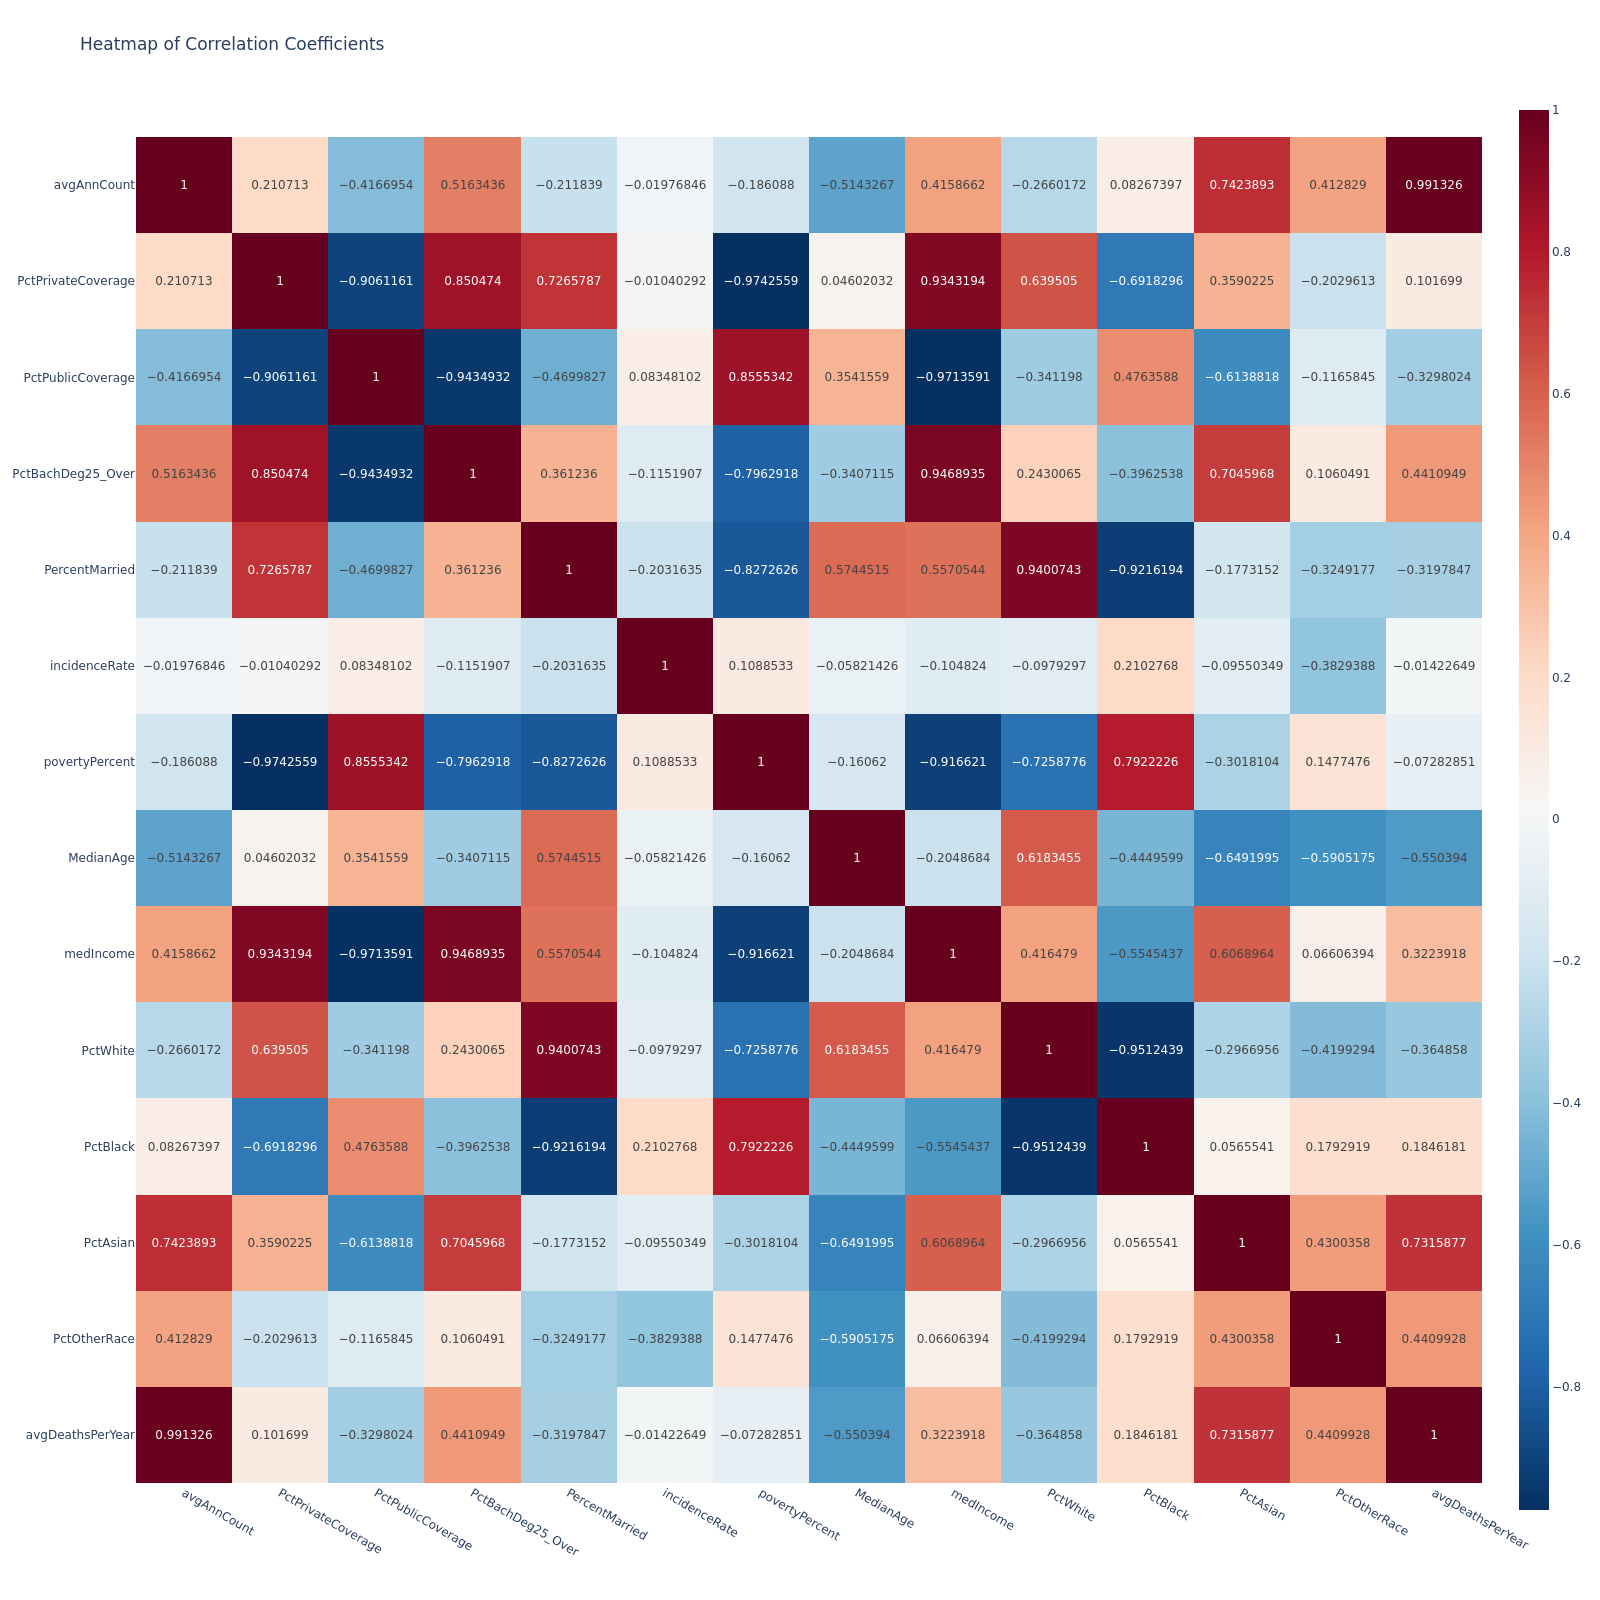

In [1260]:
corr_heatmap(df[features_in].corr(numeric_only=True), fig_type="png")

In [1261]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Partialling-Out

In [1262]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.exceptions import NotFittedError

class PartiallingOutRegressor(BaseEstimator, RegressorMixin):
    """
    Implements partialling-out (regression residualization) technique for linear models.
    
    This technique removes the linear effect of a set of covariates before estimating
    the relationship between the target variable and features of interest.
    
    Parameters:
    -----------
    fit_intercept : bool, optional (default=True)
        Whether to calculate the intercept for the internal linear model.
        If False, no intercept will be used in calculations.
        
    Attributes:
    ----------
    model_ : sklearn.linear_model.LinearRegression
        The internal linear model used for residual calculation.
        
    feature_names_ : list or None
        Names of features (only available when X is a DataFrame).
        
    Examples:
    --------
    >>> import numpy as np
    >>> from sklearn.datasets import make_regression
    >>> X, y = make_regression(n_samples=100, n_features=3, noise=0.1)
    >>> por = PartiallingOutRegressor().fit(X[:, [0,1]], y)
    >>> residuals = por.transform(X[:, [0,1]], y)
    >>> # The residuals can now be used in subsequent analysis
    
    Notes:
    ------
    - Partialling-out is commonly used in econometrics ("net of" effects)
    - Mathematically equivalent to obtaining residuals from y ~ X regression
    - Particularly useful for removing confounder effects before analysis
    """
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.model_ = None 
        
    def fit(self, X, y):
        """
        Fit the residualization model.
        
        Parameters:
        -----------
        X : array-like, DataFrame or sparse matrix of shape (n_samples, n_features)
            Features used to calculate target residuals.
            
        y : array-like of shape (n_samples,)
            Target values.
            
        Returns:
        --------
        self : object
            Returns the instance itself.
        """
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns.tolist()
            
        self.model_ = LinearRegression(fit_intercept=self.fit_intercept)
        self.model_.fit(X, y)
        
        return self
    
    def transform(self, X, y):
        """
        Calculate target residuals after removing linear effects of features.
        
        Parameters:
        -----------
        X : array-like, DataFrame or sparse matrix of shape (n_samples, n_features)
            Features used for residual calculation.
            
        y : array-like of shape (n_samples,)
            Target values to be residualized.
            
        Returns:
        --------
        residuals : array of shape (n_samples,)
            Residuals from y ~ X regression (y values with linear effect of X removed).
            
        Raises:
        -------
        NotFittedError
            If the model hasn't been fitted prior to transformation.
        """
        if self.model_ is None:
            raise NotFittedError("This model must be fitted before transformation.")
                    
        residuals = y - self.model_.predict(X)
        return residuals
    
    def set_params(self, **params):
        """
        Set the parameters of this estimator.
        
        Parameters:
        -----------
        **params : dict
            Parameters to set (name=value).
            
        Returns:
        --------
        self : object
            The estimator instance.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [1263]:
get_index = df.columns.get_indexer

residuals_mapping = {
    'avgDeathsPerYear': ['avgAnnCount', 'PctBlack', 'povertyPercent'],
    'PctPrivateCoverage': ['PctBachDeg25_Over', 'PercentMarried', 'medIncome', 'PctWhite', 'PctBlack', 'PctAsian'],
    'PctPublicCoverage': ['MedianAge', 'povertyPercent', 'PctBlack'],
    'avgAnnCount': ['PctBachDeg25_Over', 'medIncome', 'PctAsian', "PctOtherRace"],
    'PctBachDeg25_Over': ['PctAsian', 'medIncome'],
    'medIncome': ['PercentMarried', 'PctAsian', 'PctWhite'],
    'PercentMarried': ['PctWhite', 'MedianAge'],
    'MedianAge': ["PctWhite"],
    'povertyPercent': ['PctBlack'],
    "incidenceRate": ["PctPrivateCoverage"]
}

residuals = [
    (get_index(predictors), get_index([target])[0])
    for target, predictors in residuals_mapping.items()
]

def training_multiple_residual_models(data, residuals):
    residual_models = {}
    for features, target in residuals:
        X = np.asarray(data)
        y = np.asarray(data)
        residual_model = PartiallingOutRegressor()
        residual_models[target] = residual_model.fit(X[:, features], y[:, target])
    return residual_models

In [1264]:
residual_models = training_multiple_residual_models(df_train, residuals)

In [1265]:
def preprocessing(df: pd.DataFrame, residuals, models):
    df = df.copy()
    for features, target in residuals:
        X = np.asarray(df.iloc[:, features])
        y = np.asarray(df.iloc[:, target])
        df.iloc[:, target] = models[target].transform(X, y)
    return df

df_train = preprocessing(df_train, residuals, residual_models)
df_test = preprocessing(df_test, residuals, residual_models)

/tmp/ipykernel_33381/3598408924.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  53.7047406   -88.88088925  188.48543729 ...  276.27320276 -582.92617604
   44.19723705]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_33381/3598408924.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1439.1268331    163.52644926  -474.88573272 ...   160.76365508
 -7563.80696571  -505.08482663]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_33381/3598408924.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-5.85285094e+02 -4.88091341e+00  5.03789491e+01  4.68259180e+01
  3.20854749e+01  2.94184429e+01  1.28274662e+02  4.59015932e+01
  6.39836212e+01  3.28458334e+01 

In [1266]:
model = LinearRegression()
model.fit(df_train[features_in], df_train[target])
y_pred = model.predict(df_test[features_in])

In [1267]:
mse = mean_squared_error(df_test[target], y_pred)
r2 = r2_score(df_test[target], y_pred)
mse, r2

(425.32545363450515, 0.46560773150258217)

In [1268]:
model = LinearRegression()
model.fit(df_train[features_in], df_train[target])
y_pred = model.predict(df_test[features_in])

In [1269]:
mse = mean_squared_error(df_test[target], y_pred)
r2 = r2_score(df_test[target], y_pred)
mse, r2

(425.32545363450515, 0.46560773150258217)

In [1270]:
model.feature_importance_ = standardize_coefficients(model, df_train)
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)
feature_importance

,feature,std_coef
0,incidenceRate,0.406126
1,povertyPercent,0.111811
2,avgDeathsPerYear,0.083289
3,PctPublicCoverage,0.012000
4,PctBlack,-0.011578
5,avgAnnCount,-0.022379
6,PctPrivateCoverage,-0.048792
7,MedianAge,-0.056300
8,PercentMarried,-0.126617
9,PctOtherRace,-0.156932


In [1271]:
features_in = feature_importance.loc[feature_importance["std_coef"].abs() >= 0.05, "feature"].tolist()

In [1272]:
#df_train["RANDOM_1"] = np.random.normal(size=len(df_train))
#df_train["RANDOM_2"] = np.random.normal(size=len(df_train))
#df_train["RANDOM_3"] = np.random.normal(size=len(df_train))
#df_train["RANDOM_4"] = np.random.normal(size=len(df_train))
#df_train["RANDOM_5"] = np.random.normal(size=len(df_train))
#model = LinearRegression()
#model.fit(df_train[features_in + ["RANDOM_1", "RANDOM_2", "RANDOM_3", "RANDOM_4", "RANDOM_5"]], df_train[target])

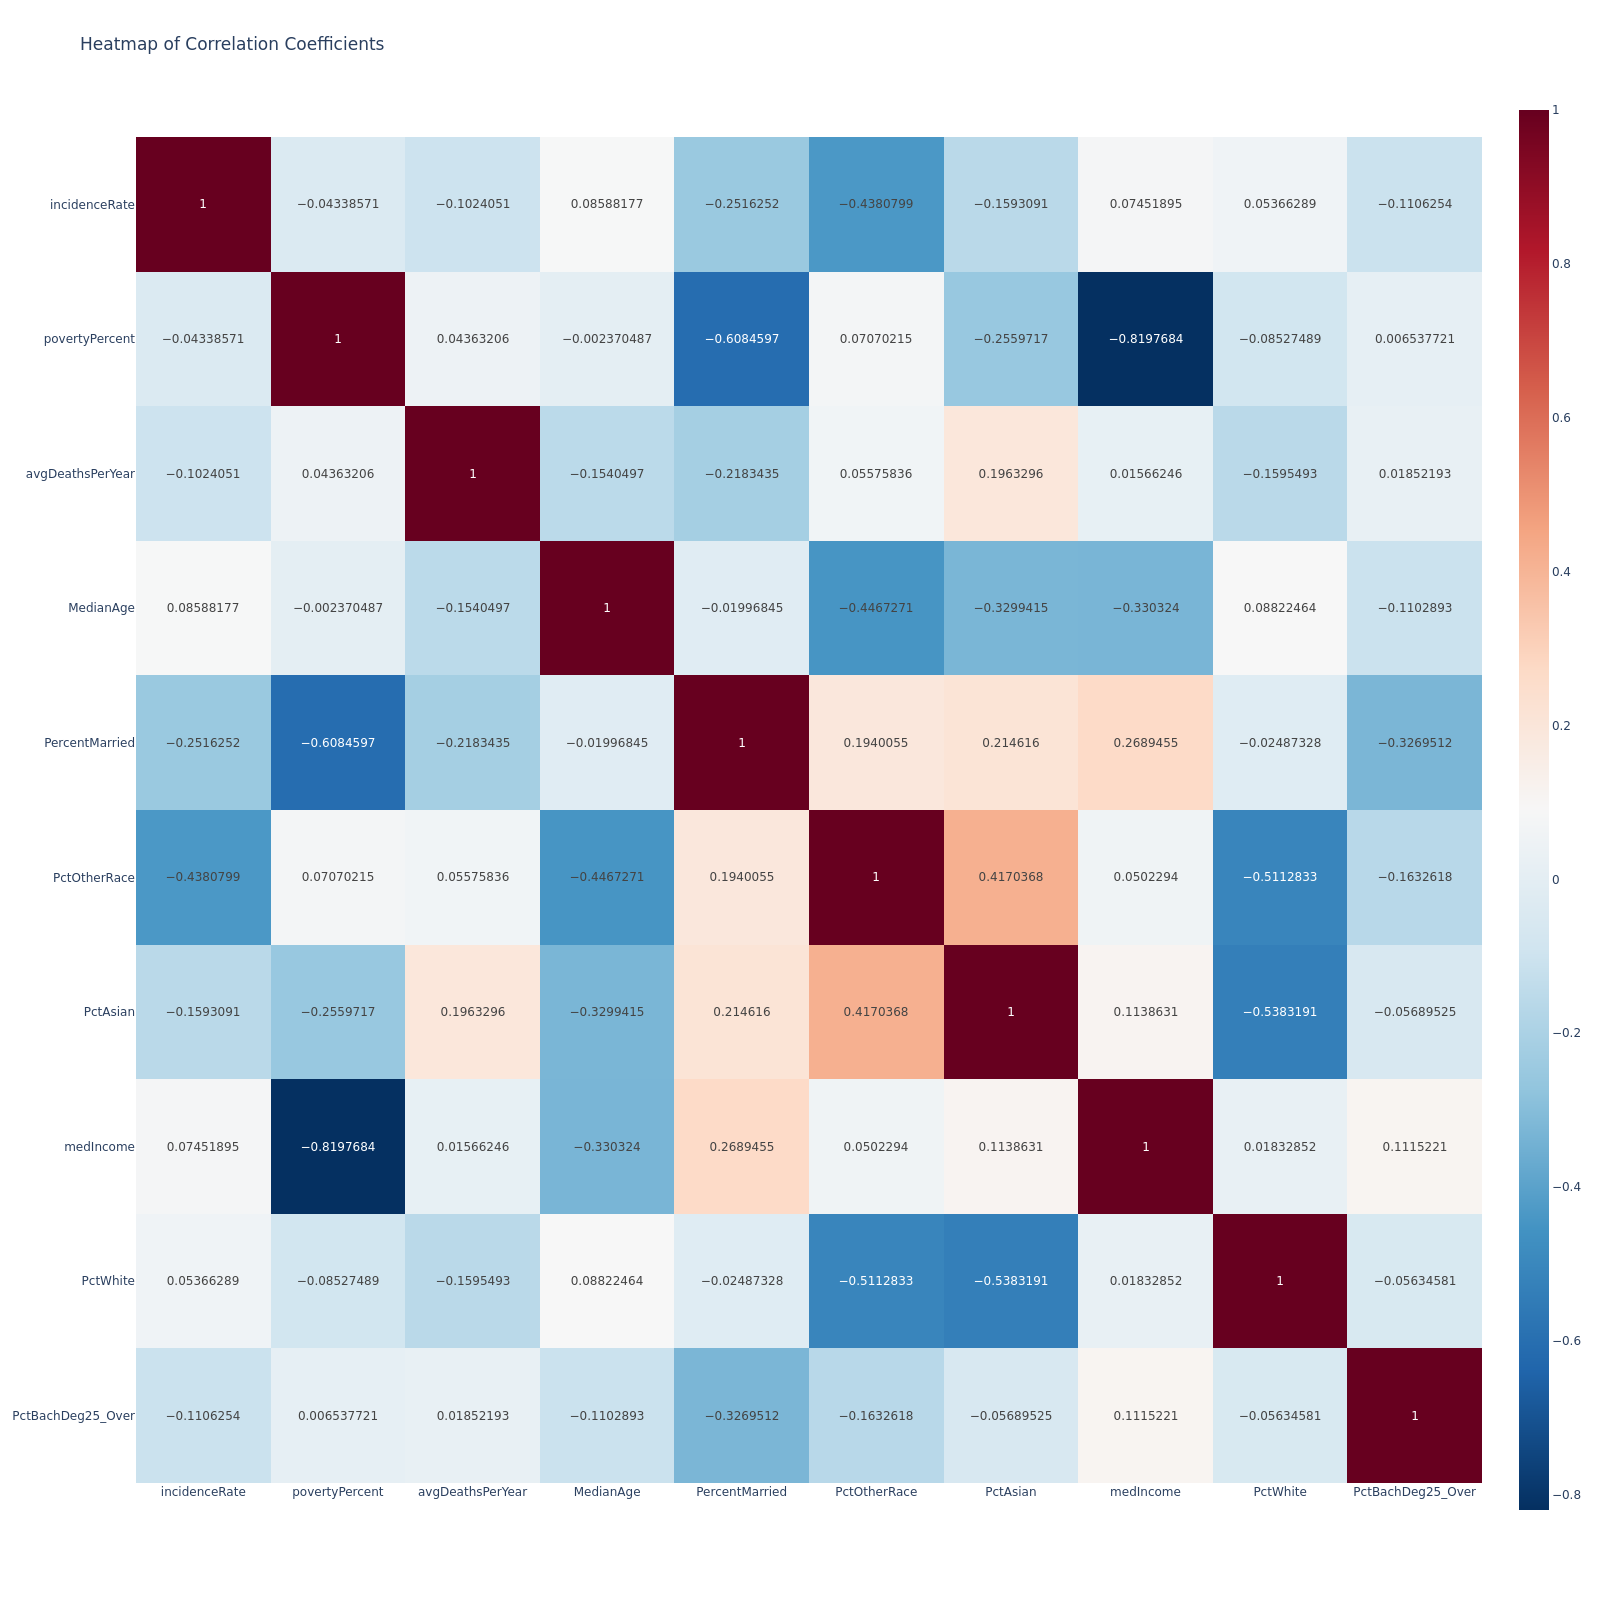

In [1273]:
corr_heatmap(df_train[features_in].corr(numeric_only=True), fig_type="png")

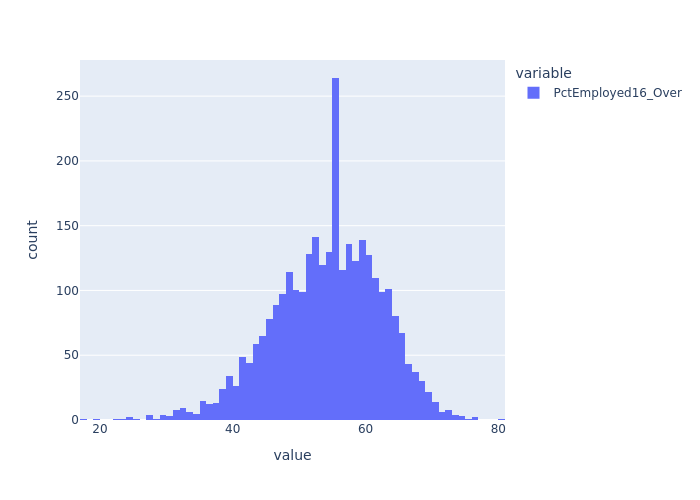

In [1274]:
px.histogram(df["PctEmployed16_Over"]).show("png")

In [1275]:
def filtering_features_based_on_vif(X: np.ndarray, threshold=15.0, verbose=False):
    """
    Filter features based on Variance Inflation Factor (VIF).
    Features with VIF above the threshold are removed iteratively."""

    if not isinstance(threshold, (int, float)):
        raise ValueError("Threshold must be a numeric value.")
    if not isinstance(verbose, bool):
        raise ValueError("Verbose must be a boolean value.")
    if X.size == 0:
        raise ValueError("Input X cannot be empty.")
    if X.shape[0] < 2:
        raise ValueError("Input X must have at least two samples.")
    if X.shape[1] < 2:
        raise ValueError("Input X must have at least two features.")

    X = np.asanyarray(X)
    features = np.ones(X.shape[1], dtype=bool)
    for _ in range(features.shape[0]):
        vif = np.zeros(features.shape[0])
        mask = np.where(features)
        vif[mask] = [variance_inflation_factor(X[:, features], i) for i in range(X[:, features].shape[1])]
        max_vif = max(vif)
        idx_max_vif = np.argmax(vif)
        if max_vif >= threshold:
            if verbose:
                print(f"Index of feature with max VIF: {idx_max_vif}")
                print(f"Removing feature with VIF: {max_vif}")
            features[idx_max_vif] = False
            continue
        else:
            break
    return features

In [1276]:
mask_features = filtering_features_based_on_vif(df_train[features_in].astype(float), threshold=5)
filtered_features = np.asarray(features_in)[mask_features]

In [1277]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

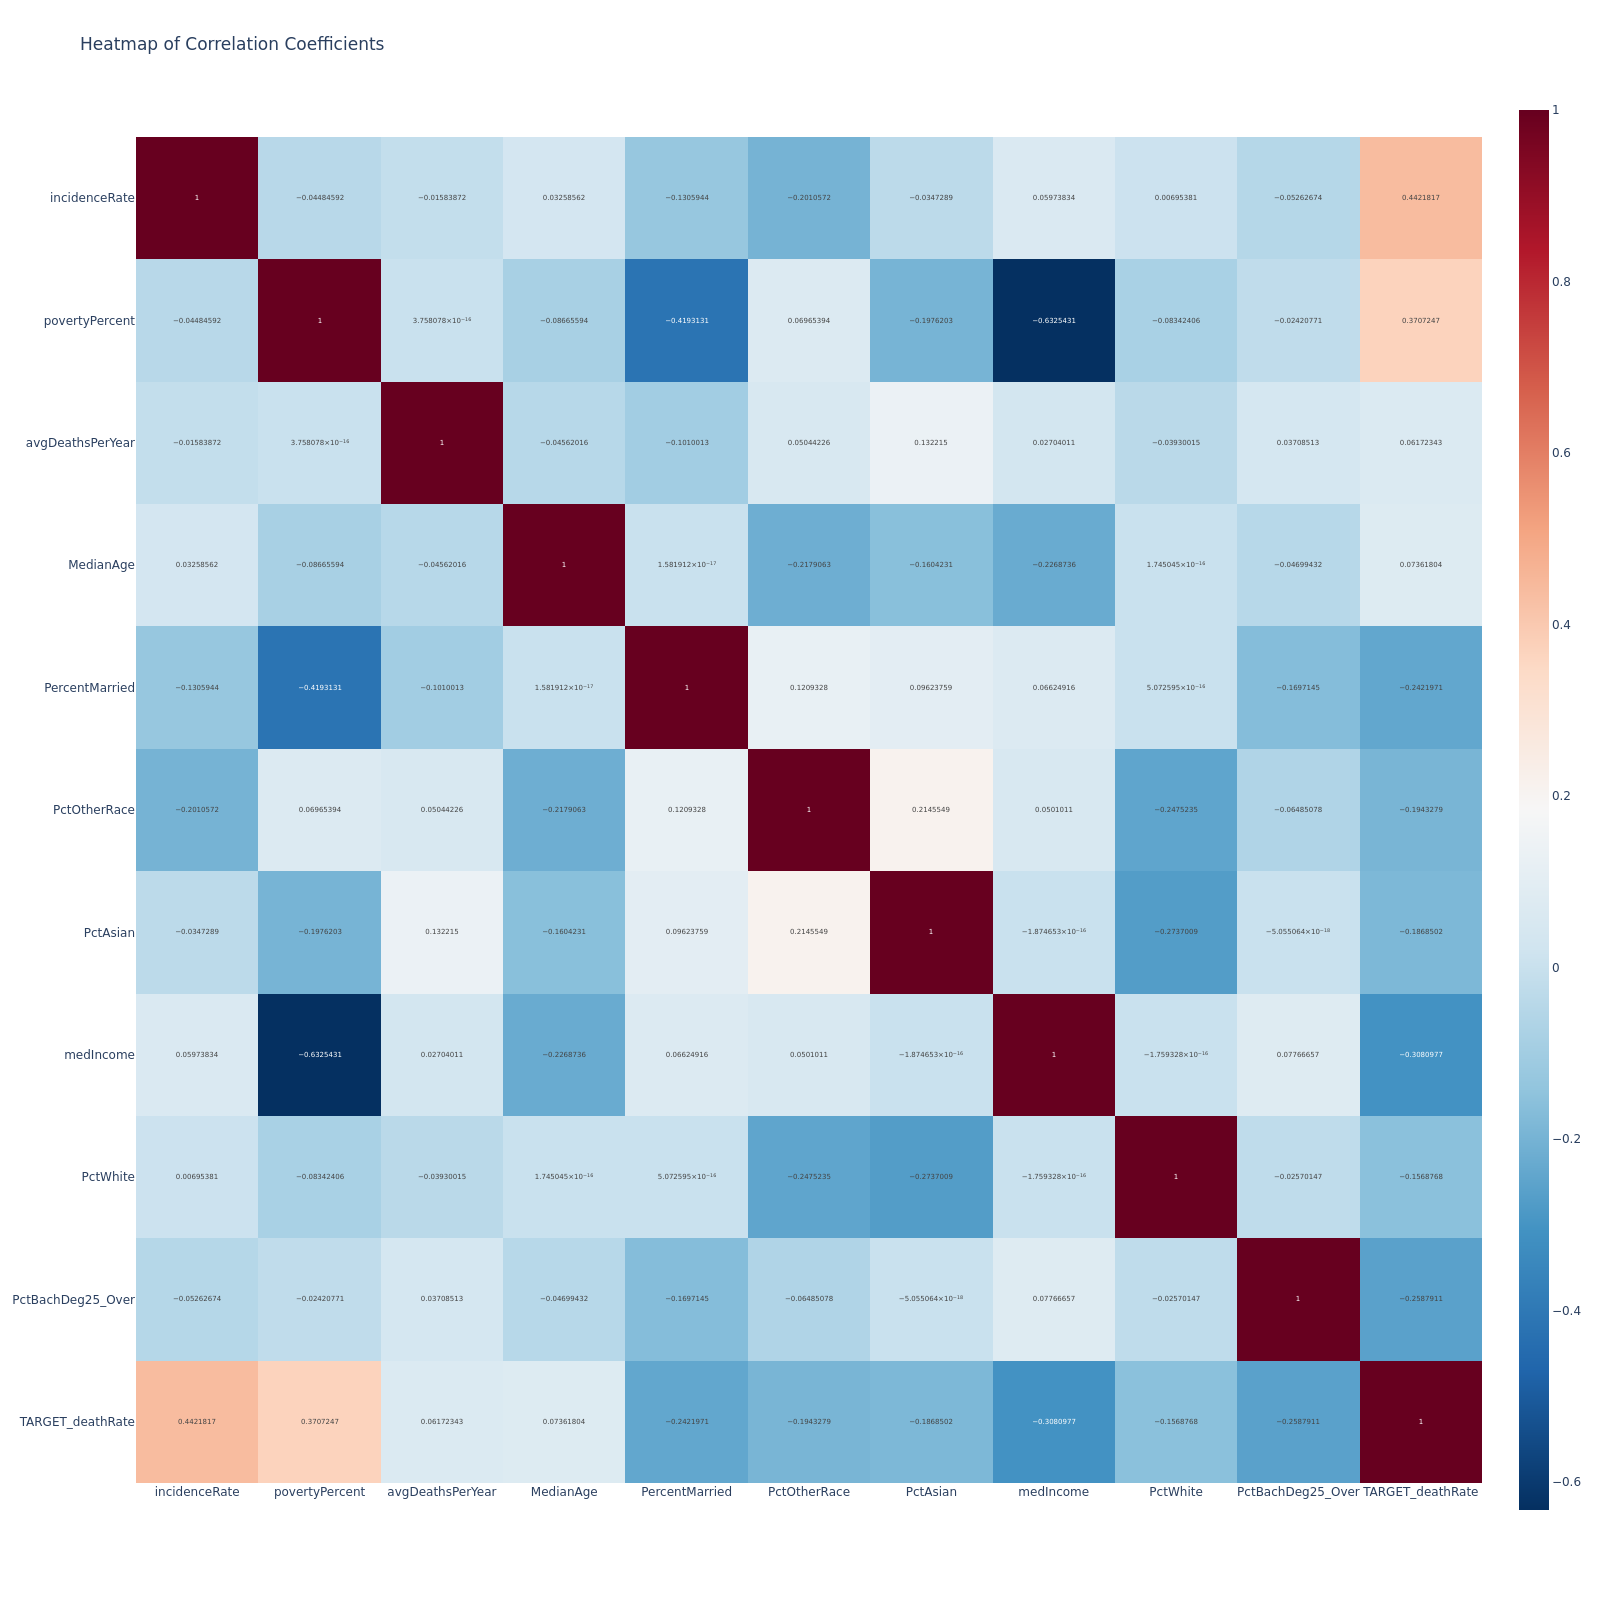

In [1278]:
corr_heatmap(df_train[filtered_features.tolist() + ["TARGET_deathRate"]], width=1600, height=1600, fig_type="png")

In [1279]:
def plot_barplot_corr_with_target(df, target='TARGET_deathRate'):
    corr = df.corr(numeric_only=True)[target].drop(target).sort_values()
    plt.figure(figsize=(8, 12))
    sns.barplot(x=corr.values, y=corr.index, palette='RdBu_r')
    plt.title(f'Correlation Coefficients from {target}')
    plt.xlabel('Correlation Coefficients')
    plt.ylabel('Feature')
    plt.show()

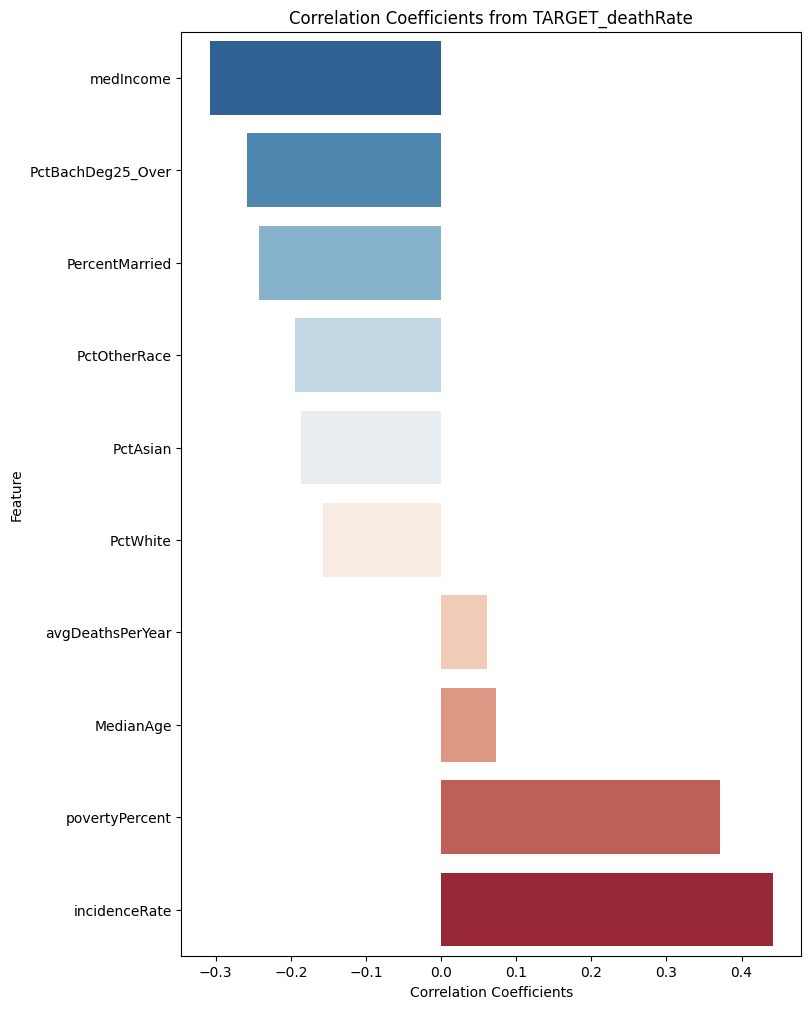

In [1280]:
plot_barplot_corr_with_target(df_train[filtered_features.tolist() + ['TARGET_deathRate']])

In [1281]:
model = LinearRegression()

In [1282]:
model.fit(df_train[filtered_features], df_train[target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [1283]:
y_pred = model.predict(df_test[filtered_features])
y_test = df_test[target]

In [1284]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse, r2

(427.45074432768064, 0.46293744947493176)

<Axes.ArtistList of 2 lines>

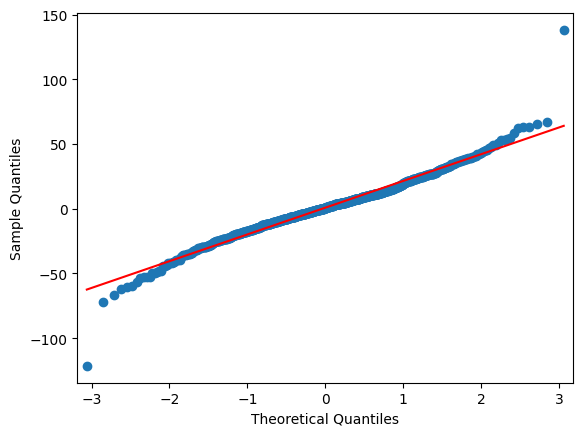

In [1285]:
residuals = y_test - y_pred
qqplot(residuals, line='s').gca().lines

In [1286]:
# Goldfeld-Quandt test
gq_test = het_goldfeldquandt(residuals, df_test[filtered_features])
print("Goldfeld-Quandt test:")
print(f"F-stat: {gq_test[0]}, p-value: {gq_test[1]}\n")

Goldfeld-Quandt test:
F-stat: 1.0222169963104368, p-value: 0.4086128680159365



In [1287]:
dw = durbin_watson(residuals)
print(f"Durbin-Watson statistic:", dw)

# DW ≈ 2: No autocorrelation.
# DW < 2: Possible positive autocorrelation.
# DW > 2: Possible negative autocorrelation.

Durbin-Watson statistic: 1.9824890750257202


In [1288]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train['TARGET_deathRate'].std()
    return std_coef

In [1289]:
model.feature_importance_ = standardize_coefficients(model, df_train)

In [1290]:
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)
feature_importance

,feature,std_coef
0,incidenceRate,0.401673
1,povertyPercent,0.149907
2,avgDeathsPerYear,0.092869
3,MedianAge,-0.045634
4,PercentMarried,-0.110968
5,PctOtherRace,-0.150342
6,PctAsian,-0.185082
7,medIncome,-0.215245
8,PctWhite,-0.238005
9,PctBachDeg25_Over,-0.257595


In [1291]:
X = sm.add_constant(df_train[filtered_features]) # add intercept
y = df_train[target]
model_sm = sm.OLS(y, X).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       TARGET_deathRate   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     207.1
Date:                Fri, 25 Jul 2025   Prob (F-statistic):          3.53e-304
Time:                        15:58:23   Log-Likelihood:                -9268.6
No. Observations:                2111   AIC:                         1.856e+04
Df Residuals:                    2100   BIC:                         1.862e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               209.8292      2.651     79.160      0.000     204.631     215.027
incidenceRate         0.2156      0.009     24.990      0.000       0.199       0.233
povertyPercent        0.7393      0.134      5.531      0.000       0.477       1.001
avgDeathsPerYear      0.0154      0.003      5.896      0.000       0.010       0.020
MedianAge            -0.2637      0.104     -2.547      0.011      -0.467      -0.061
PercentMarried       -0.6334      0.109     -5.803      0.000      -0.847      -0.419
PctOtherRace         -1.2196      0.140     -8.709      0.000      -1.494      -0.945
PctAsian             -1.9944      0.195    -10.213      0.000      -2.377      -1.611
medIncome            -0.0006   6.91e-05     -8.908      0.000      -0.001      -0.000
PctWhite             -0.4076      0.029    -14.067      0.000      -0.464      -0.351
PctBachDeg25_Over    -1.8830      0.117    -16.151      0.000      -2.112      -1.654
==============================================================================
Omnibus:                      112.318   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              409.294
Skew:                           0.091   Prob(JB):                     1.33e-89
Kurtosis:                       5.149   Cond. No.                     5.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""